In [2]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import quantstats as qs
import matplotlib.pyplot as plt

from binance import Client
from binance.enums import HistoricalKlinesType

### 抓資料並切割樣本

In [3]:
#get binance data


client = Client()
value = client.get_historical_klines(symbol = 'ETHUSDT', 
                                      interval = '15m', 
                                      start_str = '2020-01-01', 
                                      end_str = '2023-12-07',
                                      klines_type=HistoricalKlinesType.FUTURES)

columns_name = ['openTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'closeTime', 
                'quoteVolume', 'numTrade', 'takerBuyVolume', 'takerBuyQuoteVolume', 'ignore']

df = pd.DataFrame(value)
df.columns = columns_name
df['openTime']= pd.to_datetime(df['openTime'], unit='ms')
df = df.drop(['ignore', 'closeTime'], axis=1)
df = df.sort_values('openTime', ascending=True)
df = df.set_index('openTime')
df = df.astype(float)
df = df[~df.index.duplicated(keep='first')]

In [4]:
#split to in and out sample
price_all = df[['Open', 'High', 'Low', 'Close']]
price_is = price_all['2020-01-01':'2022-12-31'] # in sample data
price_os = price_all['2023-01-01':'2023-12-07'] # out sample data
print(price_all)
print(price_is)
print(price_os)

                        Open     High      Low    Close
openTime                                               
2020-01-01 00:00:00   129.12   129.12   128.65   128.87
2020-01-01 00:15:00   128.88   128.99   128.66   128.75
2020-01-01 00:30:00   128.74   128.98   128.74   128.82
2020-01-01 00:45:00   128.83   128.92   128.62   128.82
2020-01-01 01:00:00   128.81   129.19   128.76   129.12
...                      ...      ...      ...      ...
2023-12-06 23:00:00  2233.27  2234.52  2220.15  2228.61
2023-12-06 23:15:00  2228.61  2233.27  2225.01  2229.52
2023-12-06 23:30:00  2229.52  2234.43  2228.93  2234.30
2023-12-06 23:45:00  2234.29  2236.72  2229.01  2233.29
2023-12-07 00:00:00  2233.32  2237.67  2230.79  2236.80

[137857 rows x 4 columns]
                        Open     High      Low    Close
openTime                                               
2020-01-01 00:00:00   129.12   129.12   128.65   128.87
2020-01-01 00:15:00   128.88   128.99   128.66   128.75
2020-01-01 00:30:00  

### 定義策略

In [5]:
#double rsi as signal and filter
def rsi_long(close, rsi_window = 29, filter_window = 50):

    rsi_crossover = vbt.RSI.run(close, window=rsi_window).rsi_crossed_above(70).to_numpy()
    rsi_crossunder = vbt.RSI.run(close, window=rsi_window).rsi_crossed_below(30).to_numpy()

    rsi_filter = vbt.RSI.run(close, window = filter_window).rsi.to_numpy()

    signal = np.where(rsi_crossover & (rsi_filter > 70), 1, 0)
    signal = np.where(rsi_crossunder & (rsi_filter < 30), -1, signal)

    return signal

def rsi_short(close, rsi_window = 29, filter_window = 50):

    rsi_crossover = vbt.RSI.run(close, window=rsi_window).rsi_crossed_above(70).to_numpy()
    rsi_crossunder = vbt.RSI.run(close, window=rsi_window).rsi_crossed_below(30).to_numpy()

    rsi_filter = vbt.RSI.run(close, window = filter_window).rsi.to_numpy()

    signal = np.where(rsi_crossunder & (rsi_filter < 30), 1, 0)
    signal = np.where(rsi_crossover & (rsi_filter > 70), -1, signal)

    return signal

MyInd_long = vbt.IndicatorFactory(
    class_name = 'rsi_long',
    short_name = 'long',
    input_names = ['close'],
    param_names = ['rsi_window', 'filter_window'],
    output_names = ['signals'] 
).from_apply_func(rsi_long, keep_pd=True)

MyInd_short = vbt.IndicatorFactory(
    class_name = 'rsi_short',
    short_name = 'short',
    input_names = ['close'],
    param_names = ['rsi_window', 'filter_window'],
    output_names = ['signals'] 
).from_apply_func(rsi_short, keep_pd=True)


### 參數優化

In [6]:
#run strategy and do parameter optimization on in sample data

win = np.arange(20, 50)
signal = MyInd_short.run(price_is['Close'] , rsi_window=win, filter_window=win, param_product = True)

entries = signal.signals == 1
exits = signal.signals == -1

portfolio_short = vbt.Portfolio.from_signals(
    price_is['Close'], 
    entries, 
    exits,
    freq = '15m', 
    direction = 'shortonly', 
    sl_stop = 0.03,
    fees = 0.0015
)

signal = MyInd_long.run(price_is['Close'] , rsi_window=win, filter_window=win, param_product = True)

entries = signal.signals == 1
exits = signal.signals == -1

portfolio_long = vbt.Portfolio.from_signals(
    price_is['Close'], 
    entries, 
    exits,
    freq = '15m', 
    direction = 'longonly', 
    sl_stop = 0.03,
    fees = 0.0015
)

print(portfolio_long.sharpe_ratio().sort_values())
print(portfolio_short.sharpe_ratio().sort_values())

long_rsi_window  long_filter_window
32               49                    0.357882
39               48                    0.589509
33               49                    0.589990
38               43                    0.649690
20               20                    0.677708
                                         ...   
47               33                    2.151723
                 31                    2.157032
26               41                    2.274993
47               32                    2.355164
24               41                    2.401159
Name: sharpe_ratio, Length: 900, dtype: float64
short_rsi_window  short_filter_window
38                42                    -1.201811
43                33                    -1.012751
34                35                    -0.993678
43                35                    -0.984311
34                36                    -0.902165
                                           ...   
27                49                     0.998807


In [14]:
pf_long = pd.concat([portfolio_long.total_return(),  portfolio_long.sharpe_ratio()], axis=1)
pf_short = pd.concat([portfolio_short.total_return(),  portfolio_short.sharpe_ratio()], axis=1)

In [8]:
# 畫出參數高原
import plotly.graph_objects as go

x = pf.loc[pf['total_return'] > 0].index.get_level_values(0)
y = pf.loc[pf['total_return'] > 0].index.get_level_values(1)
z = pf.loc[pf['total_return'] > 0]['total_return']
data = (pf.loc[pf['total_return'] > 0]['sharpe_ratio'])
scatter_data = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        color=data,  # 将第四维数据用颜色表示
        colorscale='Viridis',
        colorbar=dict(title='Sharpe')  # 添加颜色条
    )
)

# 创建图布局
layout = go.Layout(
    title='3D Scatter Plot',
    scene=dict(
        xaxis=dict(title='rsi_window'),
        yaxis=dict(title='filter_window'),
        zaxis=dict(title='return')
    )
)

# 创建图像的 Figure 对象并绘制图像
fig = go.Figure(data=[scatter_data], layout=layout)
fig.show()
fig.write_html(file = '3d_plot.html' , auto_open  = True)#圖片儲存並自動展

NameError: name 'pf' is not defined

In [15]:
#select strategies with best sharpe ratio
#idx_best_10_sharpe = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'sharpe_ratio', ascending=False).index[0:10].to_list()
#idx_best_10_return = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'total_return', ascending=False).index[0:10].to_list()
idx_best_5_sharpe_short = pf_short.loc[np.logical_and(pf_short.index.get_level_values(0) > 25, pf_short.index.get_level_values(0) < pf_short.index.get_level_values(1))].sort_values(by = 'sharpe_ratio', ascending=False).index[0:5].to_list()
idx_best_5_sharpe_long = pf_long.loc[np.logical_and(pf_long.index.get_level_values(0) > 25, pf_long.index.get_level_values(0) < pf_long.index.get_level_values(1))].sort_values(by = 'sharpe_ratio', ascending=False).index[0:5].to_list()
#idx_best_5_return = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'total_return', ascending=False).index[0:5].to_list()
#print("best 10 sharpe: " + str(idx_best_10_sharpe))
#print("best 10 return: " + str(idx_best_10_return))
print("best 5 sharpe short: " + str(idx_best_5_sharpe_short))
print("best 5 sharpe long: " + str(idx_best_5_sharpe_long))
#print("best 5 return: " + str(idx_best_5_return))

best 5 sharpe short: [(27, 48, 'Close'), (27, 49, 'Close'), (27, 42, 'Close'), (26, 42, 'Close'), (27, 39, 'Close')]
best 5 sharpe long: [(26, 41, 'Close'), (26, 40, 'Close'), (27, 41, 'Close'), (28, 44, 'Close'), (31, 33, 'Close')]


In [16]:
entries_list = []
exits_list = []

for param in idx_best_5_sharpe_short:

    signal = MyInd_short.run(price_all['Close'] , rsi_window=param[0], filter_window=param[1], param_product = True)

    entries = signal.signals == 1
    exits = signal.signals == -1
    entries_list.append(entries)
    exits_list.append(exits)

entries_df = pd.concat(entries_list, axis = 1)
exits_df = pd.concat(exits_list, axis = 1)

portfolio_short = vbt.Portfolio.from_signals(
    price_all['Close'], 
    entries_df, 
    exits_df,
    freq = '15m', 
    direction = 'shortonly',
    sl_stop = 0.025,
    fees = 0.0015
)

print(portfolio_short.returns())

entries_list = []
exits_list = []

for param in idx_best_5_sharpe_long:

    signal = MyInd_long.run(price_all['Close'] , rsi_window=param[0], filter_window=param[1], param_product = True)

    entries = signal.signals == 1
    exits = signal.signals == -1
    entries_list.append(entries)
    exits_list.append(exits)

entries_df = pd.concat(entries_list, axis = 1)
exits_df = pd.concat(exits_list, axis = 1)

portfolio_long = vbt.Portfolio.from_signals(
    price_all['Close'], 
    entries_df, 
    exits_df,
    freq = '15m', 
    direction = 'longonly',
    sl_stop = 0.025,
    fees = 0.0015
)

print(portfolio_long.returns())

                       27                26    27
                       48    49    42    42    39
                    Close Close Close Close Close
openTime                                         
2020-01-01 00:00:00   0.0   0.0   0.0   0.0   0.0
2020-01-01 00:15:00   0.0   0.0   0.0   0.0   0.0
2020-01-01 00:30:00   0.0   0.0   0.0   0.0   0.0
2020-01-01 00:45:00   0.0   0.0   0.0   0.0   0.0
2020-01-01 01:00:00   0.0   0.0   0.0   0.0   0.0
...                   ...   ...   ...   ...   ...
2023-12-06 23:00:00   0.0   0.0   0.0   0.0   0.0
2023-12-06 23:15:00   0.0   0.0   0.0   0.0   0.0
2023-12-06 23:30:00   0.0   0.0   0.0   0.0   0.0
2023-12-06 23:45:00   0.0   0.0   0.0   0.0   0.0
2023-12-07 00:00:00   0.0   0.0   0.0   0.0   0.0

[137857 rows x 5 columns]
                           26                  27        28        31
                           41        40        41        44        33
                        Close     Close     Close     Close     Close
openTime     

,"(27, 48, Close)","(27, 49, Close)","(27, 42, Close)","(26, 42, Close)","(27, 39, Close)","(26, 41, Close)","(26, 40, Close)","(27, 41, Close)","(28, 44, Close)","(31, 33, Close)","(rp, , )","(eq, , )","(shortonly, , )","(longonly, , )"
Start Period,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01
End Period,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07
Risk-Free Rate,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Time in Market,0.27,0.28,0.31,0.28,0.31,0.44,0.43,0.45,0.45,0.47,0.07,0.92,0.41,0.65
Cumulative Return,1.37,1.33,0.97,0.91,0.54,38.09,21.92,23.58,19.16,17.8,0.06,7.96,1.09,25.58
CAGR﹪,0.16,0.16,0.13,0.12,0.08,0.9,0.73,0.75,0.69,0.67,0.01,0.47,0.14,0.78
Sharpe,0.85,0.81,0.65,0.64,0.47,1.94,1.74,1.72,1.68,1.65,0.21,2.04,0.75,1.9
Prob. Sharpe Ratio,0.96,0.95,0.9,0.9,0.83,1.0,1.0,1.0,1.0,1.0,0.66,1.0,0.93,1.0
Smart Sharpe,0.84,0.8,0.65,0.63,0.47,1.93,1.73,1.71,1.67,1.64,0.2,2.03,0.74,1.89
Sortino,1.25,1.19,0.94,0.92,0.69,2.75,2.46,2.44,2.36,2.33,0.31,2.92,1.09,2.69


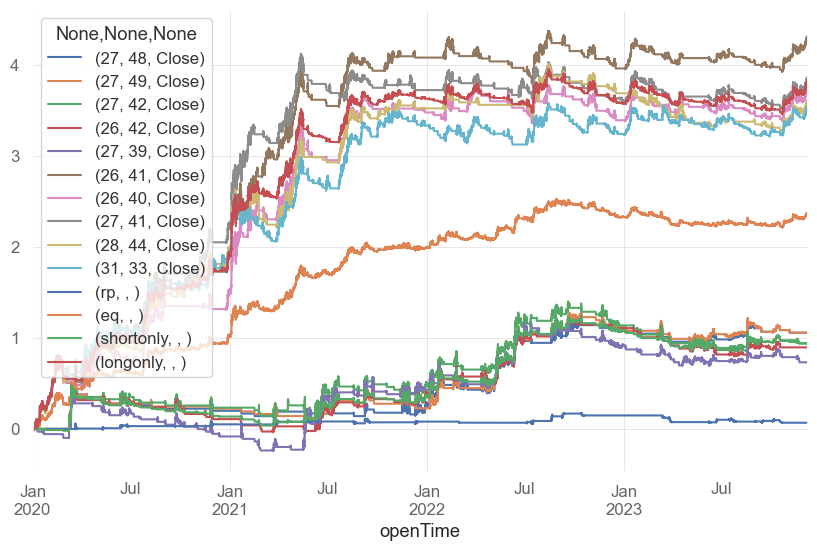

In [17]:
rett_s = portfolio_short.returns()
rett_l = portfolio_long.returns()

rett = pd.concat([rett_s, rett_l], axis=1)

n = 72 * 6
rolling_risk = rett.rolling(n).std()
w_df_ = ((1/rolling_risk).T/(1/rolling_risk).sum(axis = 1)).T

rett['rp'] = (rett * w_df_).sum(axis=1)
rett['eq'] = rett.iloc[:, :10].mean(axis = 1)
rett['shortonly'] = rett.iloc[:, :5].mean(axis = 1)
rett['longonly'] = rett.iloc[:, 5:10].mean(axis = 1)

rett.cumsum().plot()

df_metrics = pd.DataFrame()
for col in rett.columns:
    df_metrics[col] = qs.reports.metrics(rett[col], mode='full', display=False, periods_per_year =4 * 24 * 365)

df_metrics.head(50)

<Axes: title={'center': 'Cumsum'}, xlabel='openTime'>

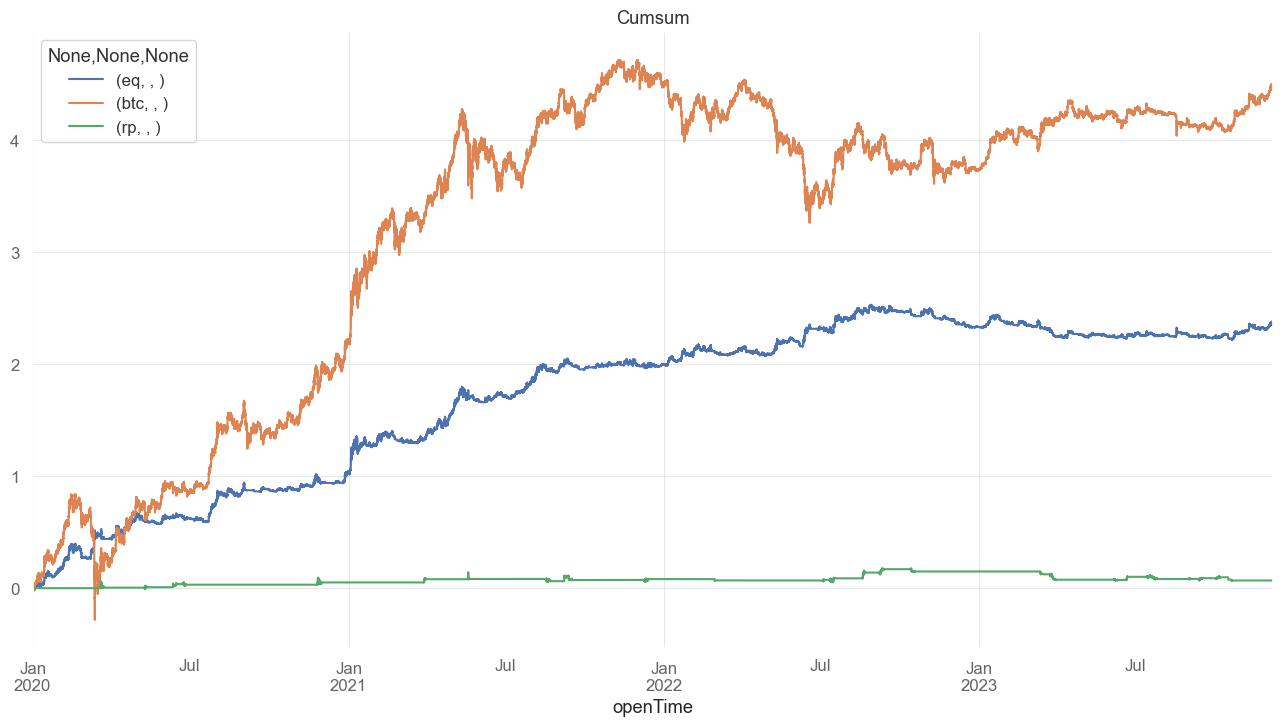

In [18]:
from datetime import datetime

rett['btc'] = df['Close'].pct_change()
fig, ax = plt.subplots(figsize=(16,8))
rett[['eq', 'btc', 'rp']].cumsum().plot(ax=ax, title = 'Cumsum')

In [19]:
qs_metrics = pd.DataFrame()

qs_metrics["benchmark"] = qs.reports.metrics(rett['btc'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded=False)
qs_metrics["eq_in_sample"] = qs.reports.metrics(rett['eq']['2020-01-01':'2022-12-31'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["eq_out_sample"] = qs.reports.metrics(rett['eq']['2023-01-01':'2023-12-07'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["eq_all"] = qs.reports.metrics(rett['eq'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["rp_in_sample"] = qs.reports.metrics(rett['rp']['2020-01-01':'2022-12-31'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["rp_out_sample"] = qs.reports.metrics(rett['rp']['2023-01-01':'2023-12-07'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["rp_all"] = qs.reports.metrics(rett['rp'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)


In [20]:
qs_metrics.head(60)
#qs_metrics.to_csv('metrics.csv')

,benchmark,eq_in_sample,eq_out_sample,eq_all,rp_in_sample,rp_out_sample,rp_all
Start Period,2020-01-01,2020-01-01,2023-01-01,2020-01-01,2020-01-01,2023-01-01,2020-01-01
End Period,2023-12-07,2022-12-31,2023-12-07,2023-12-07,2022-12-31,2023-12-07,2023-12-07
Risk-Free Rate,0,0,0,0,0,0,0
Time in Market,1.0,0.91,0.97,0.92,0.05,0.13,0.07
Total Return,4.47,2.33,0.03,2.36,0.15,-0.08,0.07
CAGR﹪,0.35,0.32,0.02,0.24,0.03,-0.06,0.01
Sharpe,1.25,2.43,0.18,2.04,0.56,-1.38,0.21
Prob. Sharpe Ratio,0.99,1.0,0.57,1.0,0.84,0.09,0.66
Smart Sharpe,1.25,2.41,0.17,2.03,0.54,-1.34,0.2
Sortino,1.78,3.46,0.26,2.92,0.85,-1.86,0.31


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-03   2020-01-03
End Period                 2023-06-30   2023-06-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       49.0%

Cumulative Return          333.6%       730.95%
CAGR﹪                     33.7%        52.07%

Sharpe                     0.93         2.05
Prob. Sharpe Ratio         96.01%       99.99%
Smart Sharpe               0.93         2.04
Sortino                    1.33         2.93
Smart Sortino              1.33         2.92
Sortino/√2                 0.94         2.07
Smart Sortino/√2           0.94         2.06
Omega                      1.06         1.06

Max Drawdown               -77.27%      -18.49%
Longest DD Days            597          168
Volatility (ann.)          74.85%       32.04%
R^2                        0.28         0.28
Information Ratio          -0.0         -0.0
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-09-13,2022-10-24,2023-01-13,123,-18.489738,-17.888808
2,2021-03-13,2021-07-10,2021-07-26,135,-17.027300,-16.891572
3,2022-03-28,2022-07-07,2022-09-12,168,-16.111033,-15.582249
4,2021-01-03,2021-01-06,2021-02-09,37,-15.164823,-14.636149
5,2023-04-26,2023-05-28,2023-06-30,65,-14.392467,-14.237723


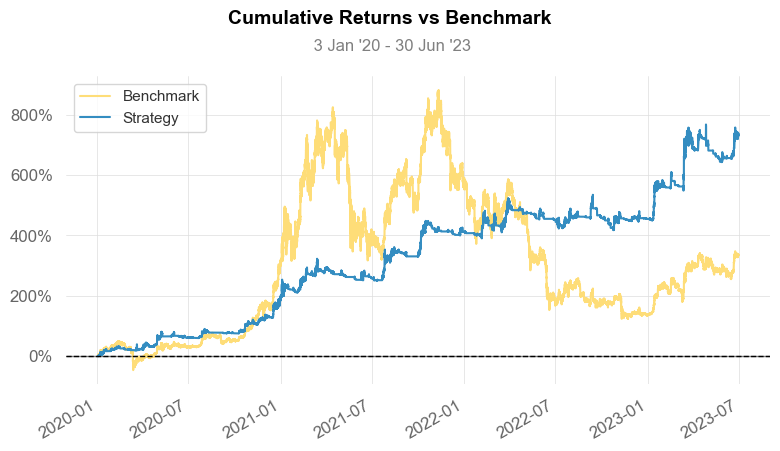

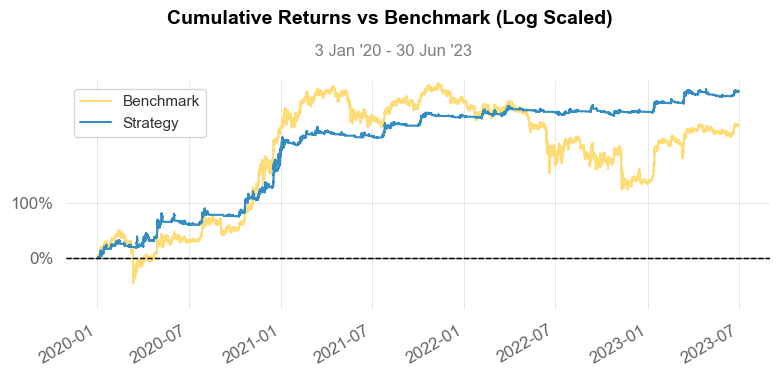

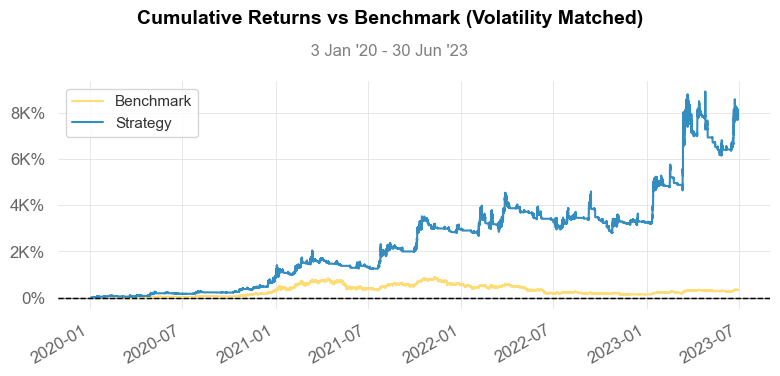

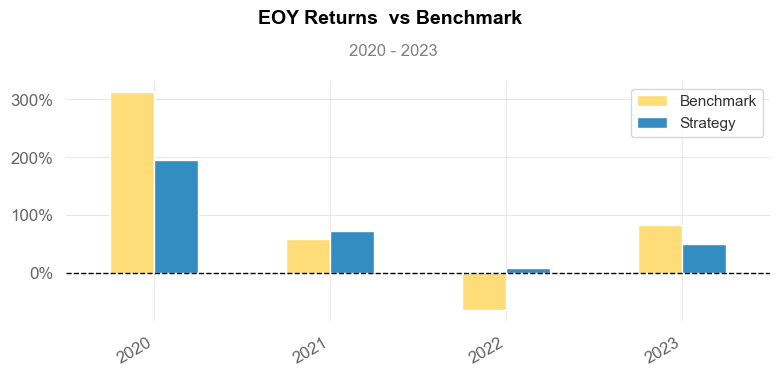

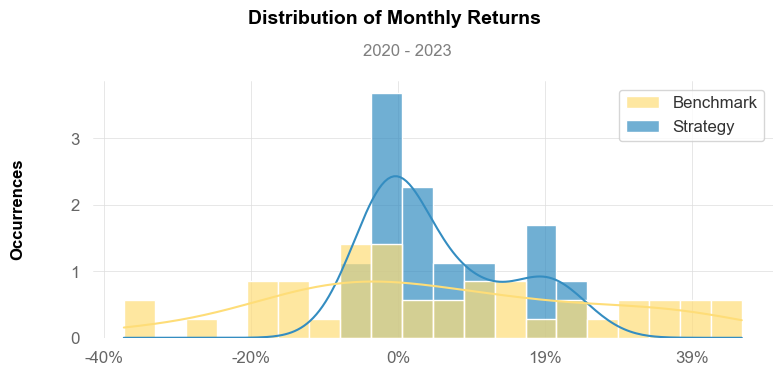

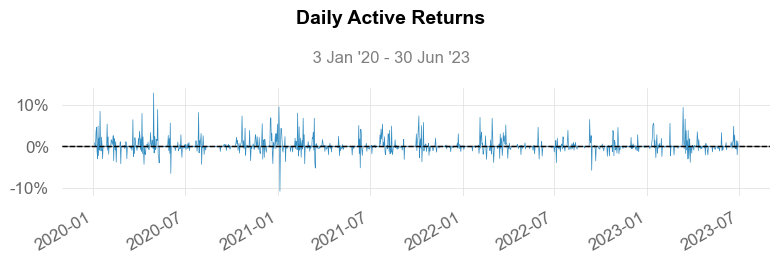

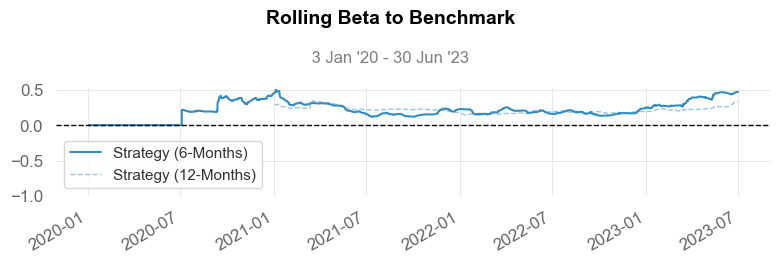

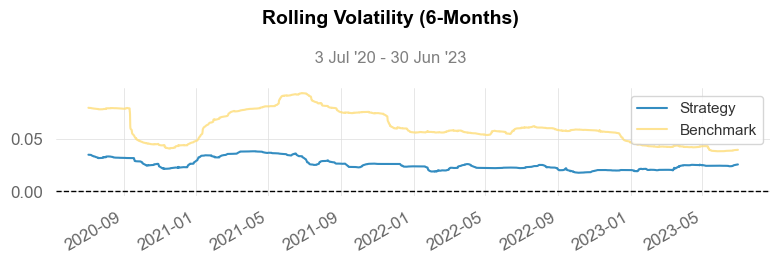

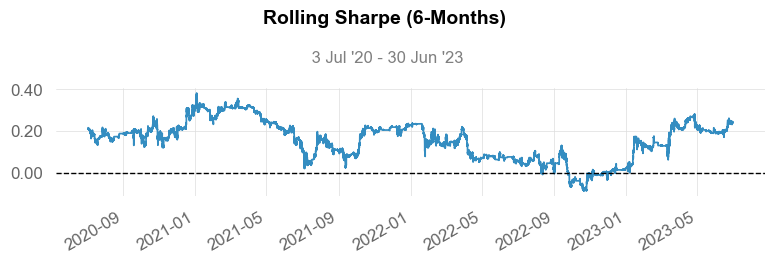

KeyboardInterrupt: 

In [26]:
qs.reports.full(rett['eq'], benchmark = rett['btc'], periods_per_year= 4 * 24 *365, compounded=True)